a: 0.32485 keV/mV
b: -42.66417 keV
                    0   1  2  predicted_energy
0   59.70588235294117  23  0        -23.268485
1   79.11764705882352  31  0        -16.962498
2   98.52941176470588  44  0        -10.656511
3  117.94117647058825  39  0         -4.350524
4  137.35294117647058  57  0          1.955464


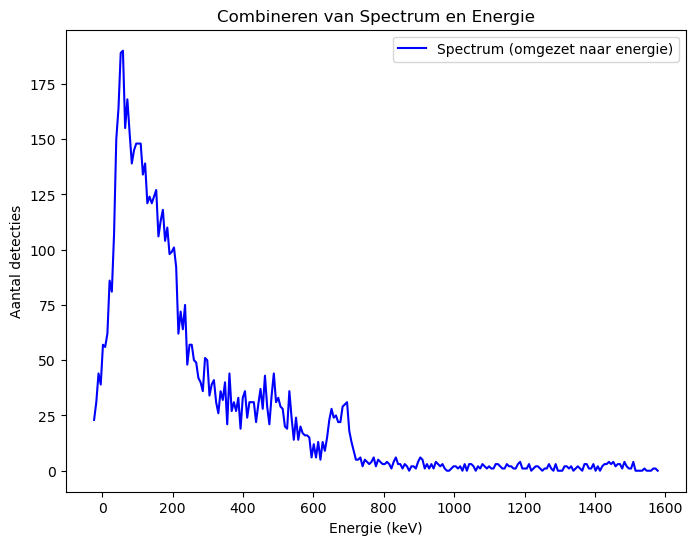

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# Je pulsehoogte-energie kalibratie
pulseheight = np.array([1691.02943, 4049.5588235, 2186.02948])  # in mV
energy = np.array([511, 1274, 662])  # in keV
energy_error = np.array([19.2] * len(energy))  # foutmarge van halve bin

def linear_function(P, a, b):  # functie voor kalibratie
    return a * P + b

# Fit de kalibratie
params, covariance = curve_fit(linear_function, pulseheight, energy)

a_fit, b_fit = params
print(f"a: {a_fit:.5f} keV/mV")
print(f"b: {b_fit:.5f} keV")

def fit_function(P):
    return a_fit * P + b_fit

# Lees het bestand in, maar splits de enkele kolom in meerdere kolommen
df = pd.read_csv('combined_spectrum.csv', sep=';', header=None)

# Splits de enkele kolom op basis van komma's
df_split = df[0].str.split(',', expand=True)

pulseheight_cesium_list = df_split.iloc[:, 0].astype(float).values  # Eerste kolom: pulsehoogte
counts_cesium = df_split.iloc[:, 1].astype(int).values 
# Zet pulsehoogte om naar energie met de kalibratiefunctie
predicted_energy = fit_function(pulseheight_cesium_list)

# Voeg de voorspelde energie toe aan de DataFrame
df_split['predicted_energy'] = predicted_energy

# Bewaar de nieuwe data in een nieuw CSV-bestand (optioneel)
df_split.to_csv('spectrum_with_energy.csv', sep=';', index=False)

# Toon de eerste paar rijen van de nieuwe dataframe met energie
print(df_split.head())

# Plot het gecombineerde spectrum
plt.figure(figsize=(8, 6))
plt.plot(predicted_energy, counts_cesium, label='Spectrum (omgezet naar energie)', color='blue')
plt.xlabel('Energie (keV)')
plt.ylabel('counts')
plt.title('Energie')
plt.legend()
plt.show()


Theoretische Compton-energie bij 18.3°: 621.29 keV
Kalibratie: a = 0.32403, b = -38.58395
Gevonden piek-energie: 622.34 keV
Gauss-fit parameters: amplitude = 33.17, piek = 335.04 keV, breedte = 250.16 keV
FWHM: 589.08 keV
Verwachte FWHM volgens resolutie (7.66%): 25.66 keV
De waargenomen breedte wijkt significant af. Controleer verdere data.


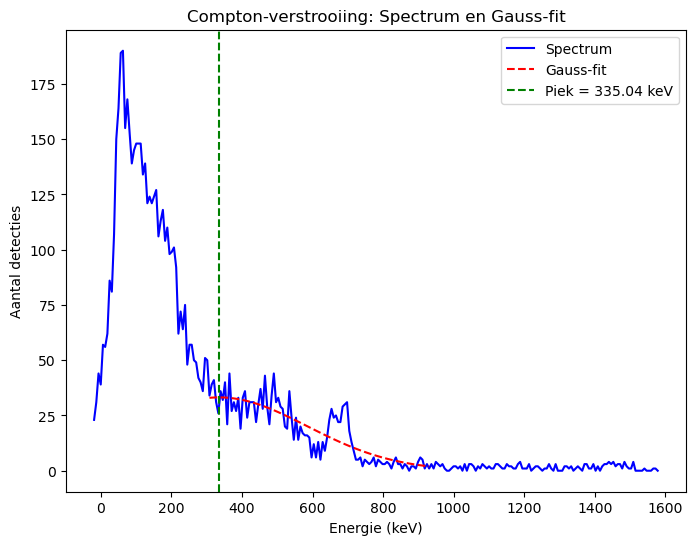

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# Compton-formule: bepaal theoretische energie
cesium_energy = 662  # Energie van de cesium-137 bron in keV
scatter_angle = 18.3  # Verstrooiingshoek in graden

# Compton-formule
compton_energy = cesium_energy / (1 + (cesium_energy / 511) * (1 - np.cos(np.radians(scatter_angle))))
print(f"Theoretische Compton-energie bij {scatter_angle}°: {compton_energy:.2f} keV")

# Detectorresolutie
resolution_percent = 7.66  # Resolutie in procent

# Functie voor Gauss-fit
def gauss_function(x, amp, cen, width):
    return amp * np.exp(-(x - cen)**2 / (2 * width**2))

# FWHM berekenen
def fwhm_from_gauss(width):
    return 2 * np.sqrt(2 * np.log(2)) * width

# Functie voor lineaire kalibratie
def linear_function(P, a, b):
    return a * P + b

# Kalibratieparameters
pulseheight = np.array([1691.02943, 4049.5588235, 2168.48])  # Pulsehoogte (mV)
energy = np.array([511, 1274, 662])  # Energie (keV)
params, _ = curve_fit(linear_function, pulseheight, energy)

a_fit, b_fit = params
print(f"Kalibratie: a = {a_fit:.5f}, b = {b_fit:.5f}")

def fit_function(P):
    return a_fit * P + b_fit

# Data inladen
df = pd.read_csv('combined_spectrum.csv', sep=';', header=None)

# Data splitsen
pulseheight_cesium_list = []
counts_cesium = []

for row in df[0]:
    values = row.split(',')  # Splits rijen met komma's
    pulseheight_cesium_list.append(float(values[0]))  # Eerste waarde: pulsehoogte
    counts_cesium.append(int(values[1]))  # Tweede waarde: tellingen

pulseheight_cesium_list = np.array(pulseheight_cesium_list)
counts_cesium = np.array(counts_cesium)

# Converteer pulsehoogte naar energie
energy_cesium = fit_function(pulseheight_cesium_list)

# Zoek piek dicht bij de verwachte Compton-energie
expected_peak_energy = compton_energy
peak_index = np.argmin(np.abs(energy_cesium - expected_peak_energy))
peak_energy = energy_cesium[peak_index]
print(f"Gevonden piek-energie: {peak_energy:.2f} keV")

# Pas een Gauss-fit toe rond de piek
fit_range = 50  # Aantal punten links en rechts van de piek
lower_bound = max(0, peak_index - fit_range)
upper_bound = min(len(energy_cesium), peak_index + fit_range)

x_fit = energy_cesium[lower_bound:upper_bound]
y_fit = counts_cesium[lower_bound:upper_bound]

p0 = [max(y_fit), peak_energy, 10]  # Voorwaarden: amplitude, piek, breedte
params_gauss, _ = curve_fit(gauss_function, x_fit, y_fit, p0=p0)

amp, cen, width = params_gauss
fwhm_value = fwhm_from_gauss(width)
print(f"Gauss-fit parameters: amplitude = {amp:.2f}, piek = {cen:.2f} keV, breedte = {width:.2f} keV")
print(f"FWHM: {fwhm_value:.2f} keV")

# Controleer of de piek binnen de detectorresolutie valt
expected_fwhm = cen * (resolution_percent / 100)
print(f"Verwachte FWHM volgens resolutie ({resolution_percent}%): {expected_fwhm:.2f} keV")
if abs(fwhm_value - expected_fwhm) < 0.1 * expected_fwhm:
    print("De waargenomen breedte komt overeen met de detectorresolutie. Het lijkt een echte piek te zijn.")
else:
    print("De waargenomen breedte wijkt significant af. Controleer verdere data.")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(energy_cesium, counts_cesium, label='Spectrum', color='blue')
plt.plot(x_fit, gauss_function(x_fit, *params_gauss), label='Gauss-fit', color='red', linestyle='--')
plt.axvline(cen, color='green', linestyle='--', label=f'Piek = {cen:.2f} keV')
plt.xlabel('Energie (keV)')
plt.ylabel('Aantal detecties')
plt.title('Compton-verstrooiing: Spectrum en Gauss-fit')
plt.legend()
plt.show()

